# Avant-propos

This could be the beginning of a good project,
there are lots of things to develop :

- I use the same method to draw l'escalier du diable can you do the Sierpinski triangle ?
- why did Barnsely choose the weights [1,84,7,7] ?
- what happens when we vary weights ?
- what happens when we perturb the matrix coefficients ?
- why is np.dot slower than the function calls ?

---

## Getting the code

To solve the exercise I got some code online at **Rosetta Code**
you can do this (a lot). Nowdays it's more imporant to be able to
read code and modify it than to write it from scratch.

But if you are going to submit modified code  as a project:

1. You have to say where you got it.
1. You should try and make the code 
    - more efficient
    - more flexible
    - easier to read
1. Use it to study something else. What about other curves and surfaces like the [blancmange](https://mathcurve.com/fractals/blancmanger/blancmanger.shtml)?

![img](https://mathcurve.com/fractals/blancmanger/blancmanger0.gif)

---

# Barnsely fern

It started with [this code](https://www.pvv.ntnu.no/~andersr/fractal/PostScript.html).

I had difficulty reading the code.
What fooled me was that 
- this wasn't recursive as I expected 
- but was doing random sampling.

This is OK as the fractal is the [attractor](https://en.wikipedia.org/wiki/Attractor)
of a (stable) dynamical system.

---

In fact it is the attractor of the iterated function system given by the set of "fern functions"

$$
m_1(x,y)1	=	[0.00 0.00; 0.00 0.16][x; y]+[0.00; 0.00] 
\\
m_2(x,y)	=	[0.85 0.04; -0.04 0.85][x; y]+[0.00; 1.60] 
\\
m_3(x,y)	=	[-0.15 0.28; 0.26 0.24][x; y]+[0.00; 0.44] 
\\
m_4(x,y)	=	[0.20 -0.26; 0.23 0.22][x; y]+[0.00; 1.60] 
$$
(Barnsley 1993, p. 86; Wagon 1991). 

These affine transformations are contractions. 

- the tip of the fern (which resembles the black spleenwort variety of fern) is the fixed point of m_2, 
- the tips of the lowest two branches are the images of the main tip under m_3 and m_4 (Wagon 1991).



In [89]:
! ../.g

[master e208d22] web
 1 file changed, 75 insertions(+), 2 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 1.21 KiB | 88.00 KiB/s, done.
Total 4 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   309fcee..e208d22  master -> master


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Random sampling

### Escalier de Cantor

This is an [attractor](https://mathcurve.com/fractals/escalierdudiable/escalierdudiable.shtml) for a system of  3 affine maps.


We programmed it using this fact:

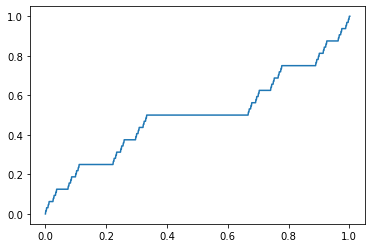

In [3]:
def mk_transforms(generators, 
                  depth=4, 
                  dim=2):
    
    elts = [np.identity(dim)]   
    for k in range(depth):
        elts.extend( [np.dot(M,G) 
                        for M in elts
                        for G in generators])
    return elts

motif = np.array([[0,0,1],[1,1,1], [2,1,1]]).T

#scaling
L = np.array( [[1/3, 0 ,0], [ 0, 1/2 ,0], [0, 0, 1]])
#scaling then translation by (2/3, 1/2)
R = np.copy(L)
R[:2,-1] = np.array([2/3, 1/2])

n = 6
transforms = mk_transforms([L,R], depth=n, dim=3)

pts = np.hstack( [np.dot(f, motif) 
                  for f in transforms[-2**n::]])
X,Y,Z = np.copy(pts)
plt.plot(X,Y);

## Random sampling

We can get a good idea of what the attractor looks like
by applying random samples from the generators.

Instead of taking **all the paths** in a tree
we are taking a **single random path**.
The properties of the affine maps mean that
the orbit of $(.5,.5)$ gives quite a good approximation.

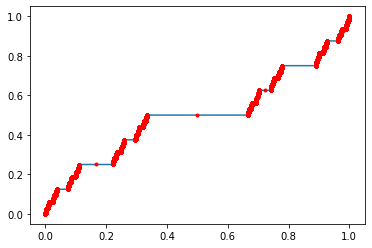

In [4]:
import random

v = np.array([.5,.5,1])
pts = []
add = pts.append
for f in random.choices( [L,R], 
                         weights=[1,1], 
                         k=20000):
    add(v)
    v = np.dot(f,v)
    
pts = np.vstack(pts)
plt.plot(X,Y);
plt.plot(pts[:,0],pts[:,1],'r.');

---

## Fern code in Python

I did a Google search using the keywords '''python, fern, fractal''' 
and found this on [Rosetta code](https://rosettacode.org/wiki/Barnsley_fern).

1. It's written as a class 
1. It uses PIL and not Matplotlib

I didn't like the cascading '''if''' statement in '''self.transforms''' 
as this hides the fact that we are using a weighted random walk.

---

This is unrelated but [interesting](https://stellargraph.readthedocs.io/en/v1.0.0rc1/demos/node-classification/node2vec/stellargraph-node2vec-weighted-random-walks.html) for graph embeddings.

In [5]:
#%%timeit

import random
from PIL import Image
 
 
class BarnsleyFern(object):
    def __init__(self, img_width, img_height, paint_color=(0, 150, 0),
                 bg_color=(255, 255, 255)):
        self.img_width, self.img_height = img_width, img_height
        self.paint_color = paint_color
        self.x, self.y = 0, 0
        self.age = 0
 
        self.fern = Image.new('RGB', (2*img_width, 2*img_height), bg_color)
        self.pix = self.fern.load()
        self.pix[self.scale(0, 0)] = paint_color
 
    def scale(self, x, y):
        h = (x + 2.182)*(self.img_width - 1)/4.8378
        k = (9.9983 - y)*(self.img_height - 1)/9.9983
        return h, k
 
    def transform(self, x, y):
        rand = random.uniform(0, 100)
        if rand < 1:
            return 0, 0.16*y
        elif 1 <= rand < 86:
            return 0.85*x + 0.04*y, -0.04*x + 0.85*y + 1.6
        elif 86 <= rand < 93:
            return 0.2*x - 0.26*y, 0.23*x + 0.22*y + 1.6
        else:
            return -0.15*x + 0.28*y, 0.26*x + 0.24*y + 0.44
 
    def iterate(self, iterations):
        for _ in range(iterations):
            self.x, self.y = self.transform(self.x, self.y)
            self.pix[self.scale(self.x, self.y)] = self.paint_color
        self.age += iterations
 
fern = BarnsleyFern(500, 500)
fern.iterate(1000000)
fern.fern.show()
 

## Some minor modifications

1. remove the method '''self.transform'''
1. cache references before the main loop in '''self.iterate'''
1. I made it use Matplotlib so that I get an image in the notebook



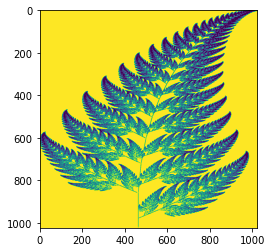

In [87]:
#%%timeit

class BarnsleyFern(object):
    
    
    def __init__(self, img_width, img_height):
        
        self.img_width, self.img_height = img_width, img_height

        self.x, self.y = 0, 0
        self.pts = []
        self.img = np.ones((self.img_width, self.img_height))
        
    def scale(self):
        X, Y = list(zip(* self.pts))
        X = [ int((x + 2.182)*(self.img_width - 1)/4.8378) for x in X]
        Y = [ int((9.9983 - y)*(self.img_height - 1)/9.9983) for y in Y]

        return X,Y
    
    def show(self):
        X, Y = self.scale()
        self.img[Y,X] = 0
        plt.imshow(self.img)
        
        
    # just to be tidy with namespace
    def m1(self,x,y):
        return 0, 0.16*y
    
    def m2(self,x,y):
        return 0.85*x + 0.04*y, -0.04*x + 0.85*y + 1.6
    
    def m3(self,x,y):
        return 0.2*x - 0.26*y, 0.23*x + 0.22*y + 1.6
    
    def m4(self, x,y):
        return -0.15*x + 0.28*y, 0.26*x + 0.24*y + 0.44

    def iterate(self, iterations):
        
        # alias everything to save lookups in the loop
        # every . is a dictionnary lookup
        x, y = self.x, self.y
        transforms = [self.m1, self.m2, self.m3, self.m4]
        add = self.pts.append
        
        #avoid using cascading ifs by using relative weights
        
        for f in random.choices(transforms, 
                                weights=[1,84,7,7], 
                                k=iterations):
            x, y = f(x,y)
            add((x,y))
            
            
 
fern = BarnsleyFern(1024, 1024)
fern.iterate(1000000)
fern.show()

this is about 25% quicker probably from aliasing

## Rewrite using numpy

This is actually slower as '''np.dot'''
is slow on small matrices.

In [10]:
#%%timeit
import random
import numpy as np
from PIL import Image

class BarnsleyFern(object):
    
    
    def __init__(self, img_width, img_height, paint_color=(0, 150, 0),
                 bg_color=(255, 255, 255)):
        
        self.img_width, self.img_height = img_width, img_height
        self.paint_color = paint_color
        self.x, self.y = 0, 0
        self.v = np.array([self.x, self.y,1])
 
        self.fern = Image.new('RGB', (img_width, img_height), bg_color)
        self.pix = self.fern.load()
        
        
        #I got a sign wrong and it took an hour to find it!!!!
        self.generators = [ [0.00, 0.00, 0.00, 0, 0.16, 0.00 ],
              [ 0.85,  0.04, 0, -0.04,  0.85,  1.6],
              [  0.2, -0.26, 0,  0.23,  0.22,  1.6 ],
              [-0.15,  0.28, 0,  0.26,  0.24, 0.44 ]
             ]
        
        # these values shouldn't be hard coded
        # we should probably get them from the fixed points
        mm = np.array([[1,0, 2.182], [0,-1,9.9983 ], [0,0,1]])
        
        mm[0] = mm[0]*(self.img_width - 1)/4.8378
        mm[1] = mm[1]*(self.img_height - 1)/9.9983
        self.scale = mm
        
        x,y,z = self.scale.dot(self.v)
        self.pix[x,y] = paint_color
        
        
    
    def mk_transforms(self, shuffle=False):
        def coeffs2matrix(m):
             return np.vstack((np.array(m).reshape(2,3), 
                               np.array([0,0,1])))
                     
        matrices = [ coeffs2matrix(m)  for m in self.generators]
        
        if not shuffle: 
            return [ f.dot for f in matrices]
        #this adds noise to the coeeficients          
        shuffles = [ (np.random.random((2,3)) - .5)*0.01 for k in range(4)]
        shuffles[0] = np.zeros((2,3))
        
        for a,b in zip(matrices, shuffles):
            a[:2,:3] = a[:2,:3] + b
            
        return matrices


    def iterate(self, iterations):
        
        # cache everything to save lookups in the loop
        # remember every . is a dictionnary lookup
        v = self.v
        img, scale, color  = self.pix, self.scale.dot, self.paint_color
        
        transforms = self.mk_transforms()
        #avoid using cascading ifs by using relative weights
        for f in random.choices( transforms, 
                                weights=[1,80,10,10], 
                                k=iterations):
            
            #np.dot is matrix multiplication
            v = f(v)
            w = scale(v)
            img[w[0],w[1]] = color
            
 
fern = BarnsleyFern(500, 500)
fern.iterate(1000000)
fern.fern.show()

# this is slower I wonder what the overhead is 

---

## Doing experiments


$$
m_1(x,y)1	=	[0.00, 0.00; 0.00, 0.16][x; y]+[0.00; 0.00] 
\\
m_2(x,y)	=	[0.85,0.04; -0.04, 0.85][x; y]+[0.00; 1.60] 
\\
m_3(x,y)	=	[-0.15, 0.28; 0.26, 0.24][x; y]+[0.00; 0.44] 
\\
m_4(x,y)	=	[0.20, -0.26; 0.23,  0.22][x; y]+[0.00; 1.60] 
$$



(Barnsley 1993, p. 86; Wagon 1991). 

According to Wolfram : these affine transformations are contractions. 

- the tip of the fern (which resembles the black spleenwort variety of fern) is the fixed point of m_2, 
- the tips of the lowest two branches are the images of the main tip under m_3 and m_4 (Wagon 1991).

---

## Finding the fixed points

There are 2 ways to calculate the fixed points :
- solve a linear system $m_i(x,y) = (x,y)$.
- iterate $m_i$ and take the limit

## Experimenting

We'll study a slightly simpler system that can be programmed 
without using random sampling.

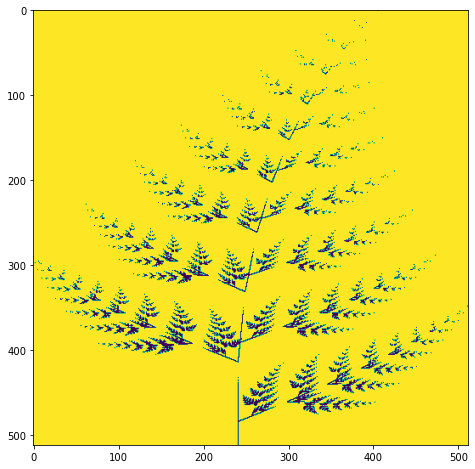

In [7]:
#%%timeit


def normalize(X, size=512):
    M, m = max(X), min(X)
    X = (size - 1)*(X - m )/(M - m)
    return X.astype(int)

    
generators = [ [0.00, 0.00, 0.00, 0, 0.16, 0.00 ],
              [ 0.85,  0.04, 0, -0.04,  0.85,  1.6],
              [  0.2, -0.26, 0,  0.23,  0.22,  1.6 ],
              [-0.15,  0.28, 0,  0.26,  0.24, 0.44 ]
             ]


matrices = [ np.array(g).reshape(2,3) for g in generators ]
# this is a list of funtions !!!
transforms = [ np.vstack([f,np.array([0,0,1])]).dot for f in matrices]


u = np.array([ [0,0, 1] ] ).reshape(-1,1)
v = []
for k  in range(4):
    u = transforms[0](u)
    v.append(u)
    
v = np.hstack(v)

for k in range(10):  
    # transforms is a list of functions
    v = np.hstack([f(v) for f in transforms ])

    
# make an image from the array
ss = 512
img = np.ones((ss, ss))
img[normalize( 1- v[1]) , normalize( v[0]) ] = 0.

fig, ax = plt.subplots()
fig.set_size_inches(8,8)
ax.set_aspect('equal')

ax.imshow(img);

In [8]:
v.shape

(3, 4194304)

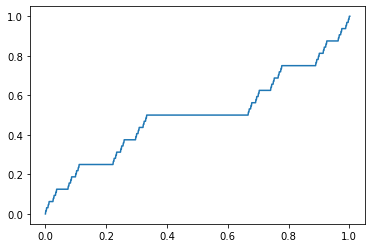

In [9]:
def mk_transforms(generators, 
                  depth=4, 
                  dim=2):
    
    elts = [np.identity(dim)]   
    for k in range(depth):
        elts.extend( [np.dot(M,G) 
                        for M in elts
                        for G in generators])
    return elts

motif = np.array([[0,0,1],[1,1,1], [2,1,1]]).T

#scaling
L = np.array( [[1/3, 0 ,0], [ 0, 1/2 ,0], [0, 0, 1]])
#scaling then translation by (2/3, 1/2)
R = np.copy(L)
R[:2,-1] = np.array([2/3, 1/2])

n = 6
transforms = mk_transforms([L,R], depth=n, dim=3)

pts = np.hstack( [np.dot(f, motif) 
                  for f in transforms[-2**n::]])
X,Y,Z = pts
plt.plot(X,Y);

In [60]:
! ../.g


[master 4a528cb] web
 1 file changed, 386 insertions(+), 158 deletions(-)
Counting objects: 4, done.
Delta compression using up to 12 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 251.09 KiB | 3.49 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/macbuse/macbuse.github.io.git
   80d47ac..4a528cb  master -> master


----

## Linear algebra to find fps

Each affine transformation is of the form

$\vec{v} \mapsto A.\vec{v} + \vec{b}$

for $A\in \text{GL}_{n} (\mathbb{K}), \vec{b} \in \mathbb{K}^n$ 

So a fixed point satisfies

$A.\vec{v} + \vec{b} = \vec{v}$

simplifying

$(A -I_2).\vec{v} = -\vec{b}.$

This linear system is easy to solve with '''np.linalg.solve'''.

In [90]:
for A in matrices:
    
    a, b = A[:2, :2] - np.identity(2), - A[:,2]
    print(np.linalg.solve(a,b))

[0. 0.]
[2.65560166 9.95850622]
[-0.60836502  1.87189237]
[0.15376935 0.63155267]


In [91]:
for A in matrices:
    print(np.abs(np.linalg.eigvals(A[:2, :2])))

[0.   0.16]
[0.85094066 0.85094066]
[0.32218007 0.32218007]
[0.28790389 0.37790389]


## Iteration 

The iteration for an affine map  converges at a speed
that depends on (the $\log$ of) the absolute value of the biggest eigenvalue.

For example  0.85 is quite big but 0.32218007 is much smaller.
The iteration for $m_3$ should converge 7 times faster than for $m_2$.


---

This is [interesting](https://perso.uclouvain.be/paul.vandooren/publications/BlondelNV04.pdf).

These iterations occur in the definition of the PageRank of a webpage [1]
and in the calculation of the similarity matrix of two graphs, which was
recently introduced by several authors [3, 6, 8].

[6] G. Jeh, J. Widom, SimRank: A measure of structural-context similarity, Proc.
of the KDD2002 Conf., Edmonton (2002)


In [94]:
np.log(.322)/np.log(.85)

6.9727491864462685

In [33]:
u = np.array([ [0,0, 1] ] ).reshape(-1,1)

for k  in range(25):
    u = transforms[0](u)
    if k >20: # converges very slowly
        print(u)
    

[[2.3710369 ]
 [9.87801294]
 [1.        ]]
[[2.41050188]
 [9.90146952]
 [1.        ]]
[[2.44498538]
 [9.91982902]
 [1.        ]]
[[2.47503073]
 [9.93405525]
 [1.        ]]
